# Redes Convolucionais

Neste exemplo prático, falaremos sobre as redes neurais convolucionais. O exemplo será dividido nos seguintes tópicos:

- Classificação CIFAR10
- Definição da Rede Neural (LeNet)
- Treinamento
- Avaliação
- *Feature Map*

## Classificação CIFAR10

O exemplo aqui descrito será feita sobre a base de dados [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). O CIFAR10 é um dataset de 60.000 imagens RGB (50.000 para treinamento e 10.000 para teste) com dimensões 32x32, contendo 10 classes. Esse exemplo foi inspirado no [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) do Pytorch.

In [ ]:
# Bibliotecas para essa seção:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import plotly.express as px
from plotly.subplots import make_subplots

### Download do Dataset

In [ ]:
batch_size = 8

# Transformações e Normalização dos dados
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Dataloaders para minibatchs
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes da CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 41044782.47it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Mostrando algumas imagens

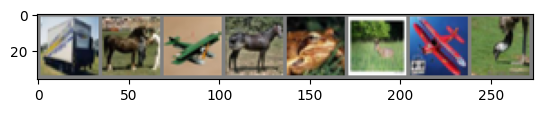

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Função de mostrar as imagens
def imshow(img):
    img = img / 2 + 0.5     # desnormalização
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Imagens aleatórias
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Mostrando umagens
imshow(torchvision.utils.make_grid(images))

## Definição da Rede Neural

A rede proposta tem camadas convolucionais, *batch normalization*, função de ativação e *pooling*.


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.norm1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.norm2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.norm2(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [ ]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Treinamento

In [ ]:
# Função de Perda e Otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Adicionando ao cuda
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Alocando o modelo ao dispositivo disponível
model.to(DEVICE)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Treinamento
for epoch in range(50):  # Iterações sobre todo o dataset de treino: 10

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'Epoca: {epoch + 1} - Loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoca: 1 - Loss: 1.700
Epoca: 1 - Loss: 1.474
Epoca: 1 - Loss: 1.387
Epoca: 2 - Loss: 1.303
Epoca: 2 - Loss: 1.269
Epoca: 2 - Loss: 1.240
Epoca: 3 - Loss: 1.185
Epoca: 3 - Loss: 1.174
Epoca: 3 - Loss: 1.147
Epoca: 4 - Loss: 1.085
Epoca: 4 - Loss: 1.109
Epoca: 4 - Loss: 1.094
Epoca: 5 - Loss: 1.036
Epoca: 5 - Loss: 1.035
Epoca: 5 - Loss: 1.055
Epoca: 6 - Loss: 0.965
Epoca: 6 - Loss: 0.996
Epoca: 6 - Loss: 1.026
Epoca: 7 - Loss: 0.941
Epoca: 7 - Loss: 0.952
Epoca: 7 - Loss: 0.970
Epoca: 8 - Loss: 0.904
Epoca: 8 - Loss: 0.926
Epoca: 8 - Loss: 0.941
Epoca: 9 - Loss: 0.875
Epoca: 9 - Loss: 0.898
Epoca: 9 - Loss: 0.907
Epoca: 10 - Loss: 0.855
Epoca: 10 - Loss: 0.863
Epoca: 10 - Loss: 0.890
Epoca: 11 - Loss: 0.836
Epoca: 11 - Loss: 0.849
Epoca: 11 - Loss: 0.861
Epoca: 12 - Loss: 0.813
Epoca: 12 - Loss: 0.836
Epoca: 12 - Loss: 0.838
Epoca: 13 - Loss: 0.799
Epoca: 13 - Loss: 0.813
Epoca: 13 - Loss: 0.828
Epoca: 14 - Loss: 0.778
Epoca: 14 - Loss: 0.796
Epoca: 14 - Loss: 0.818
Epoca: 15 - Loss: 0

In [ ]:
# Salvando os pesos da rede treinada:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

## Avaliação

Neste tópico será visto a aplicação do modelo sobre o conjunto de teste e as métricas de avaliação. As métricas serão *accuracy*, *precision*, *recall* e *f1-score*

In [ ]:
# importando métricas do Sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Carregando o modelo e os pesos salvos
model = Net()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# Aplicando sobre o conjunto de treino

final_preds, final_reals = [],[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Cálculo das saídas dos modelos
        outputs = model(images)
        # A classe com maior probabilidade é a definida.
        _, predicted = torch.max(outputs.data, 1)
        final_reals.append(labels.numpy())
        final_preds.append(predicted.numpy())

final_preds = np.hstack(final_preds)
final_reals = np.hstack(final_reals)


In [ ]:
# Cálculo das métricas:
acc = accuracy_score(final_reals, final_preds)
precision = precision_score(final_reals, final_preds, average='weighted')
recall = recall_score(final_reals, final_preds, average='weighted')
fscore = f1_score(final_reals, final_preds, average='weighted')

print(f"Acuracia: {acc} - Precisão: {precision} - Recall: {recall} - FScore: {fscore}")


Acuracia: 0.6206 - Precisão: 0.6193649044418247 - Recall: 0.6206 - FScore: 0.6192586796348353
